**Řešíme 2D úlohu konekce:**
$$\begin{align*}
    \frac{\partial u}{\partial t} + \beta \frac{\partial u}{\partial x} &= 0, \quad x \in [0, 2\pi],\,t\in[0, 1] \\
    u(x, 0) &= \sin(x) + \cos(x) \\
    u(0, t) &= u(2\pi, t),
\end{align*}$$
kde $\beta > 0$ je koeficient konvekce. Analytické řešení je
$$\begin{equation*}
    u(x, t) = \sin(x - \beta t) + \cos(x - \beta t).
\end{equation*}$$
Níže natrénujeme model řešící tuto úlohu, a poté jej porovnáme se správným řešením úlohy.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Zakladni importy
import torch
from torch.optim.lr_scheduler import StepLR
import numpy as np
import sys

In [3]:
# Import vlastnich modulu
sys.path.append("..")
import src.data.square_domain as sq
from src.models.mlp_model import MLPModel
from src import train
from src import calculus as calc
from src import utils

In [4]:
# Volba spravneho device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Definice ztratove funkce

BETA = 10 # BETA -- konstanta konvekce

# BETA neni argument funkce, protoze kazdy trenovaci algoritmus ocekava, ze 
# jako argument jen a pouze model a domena.
def loss_fn(model: torch.nn.Module, domain: sq.SquareDomain) -> torch.Tensor:
    _, u_x, u_t = calc.compute_derivatives_2d(model, domain.interior)
    pde_loss = torch.mean((u_t + BETA * u_x)**2)

    u_bottom = model(domain.bottom_boundary)
    left_loss = torch.mean((u_bottom - torch.sin(domain.bottom_boundary[:, 0:1]) 
                            - torch.cos(domain.bottom_boundary[:, 0:1]))**2)

    u_left = model(domain.left_boundary)
    u_right = model(domain.right_boundary)
    top_bot_loss = torch.mean((u_left - u_right)**2)

    return pde_loss + left_loss + top_bot_loss


In [6]:
# Definice modelu, domeny problemu a optimalizatoru
config = sq.SquareDomainConfig(
    x_0=0,
    x_1=2*np.pi,
    y_0=0,
    y_1=1,
    mirror_right_left=True,
    device=device,
    interior_strategy='latin',
    N_int=2_000,
    N_left=200,
    N_right=200,
    N_top=200,
    N_bottom=200
)

model = MLPModel(2, 1, [40, 40, 40, 40, 40]).to(device)
domain = sq.SquareDomain(config)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer=optimizer, step_size=2_000, gamma=0.1)

In [ ]:
# Trenujeme algoritmus a ukladame hodnoty ztraty
context = train.TrainingContext(
    model=model,
    optimizer=optimizer,
    domain=domain,
    loss_fn=loss_fn,
    epochs=300
)

BETAS = [0.1, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
loss_values = []

for BETA in BETAS:
    print(f"Current BETA: {BETA}")
    new_vals = train.train_switch_to_lbfgs(context, epochs_with_lbfgs=500, lbfgs_lr=0.1)
    loss_values += new_vals

Current BETA: 0.1
Loss at epoch 1 is: 1.0599315166473389
Loss at epoch 100 is: 0.08446807414293289
Loss at epoch 200 is: 0.031180961057543755
Loss at epoch 300 is: 0.011778515763580799
Switching to LBFGS
Loss at lbfgs-epoch 100 is: 0.00020658592984545976
Loss at lbfgs-epoch 200 is: 4.5300766942091286e-05
Loss at lbfgs-epoch 300 is: 4.5300766942091286e-05
Loss at lbfgs-epoch 400 is: 4.5300766942091286e-05
Loss at lbfgs-epoch 500 is: 4.5300766942091286e-05
Current BETA: 1
Loss at epoch 1 is: 0.811711311340332
Loss at epoch 100 is: 0.2289961576461792
Loss at epoch 200 is: 0.08358438313007355
Loss at epoch 300 is: 0.006154167465865612
Switching to LBFGS
Loss at lbfgs-epoch 100 is: 0.00012496818089857697
Loss at lbfgs-epoch 200 is: 9.692918683867902e-05
Loss at lbfgs-epoch 300 is: 9.692918683867902e-05
Loss at lbfgs-epoch 400 is: 9.692918683867902e-05
Loss at lbfgs-epoch 500 is: 9.692918683867902e-05
Current BETA: 2
Loss at epoch 1 is: 1.0022690296173096
Loss at epoch 100 is: 0.142278432846

/home/berva/Projects/PINNs/Introduction/notebooks/../src/utils.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels)


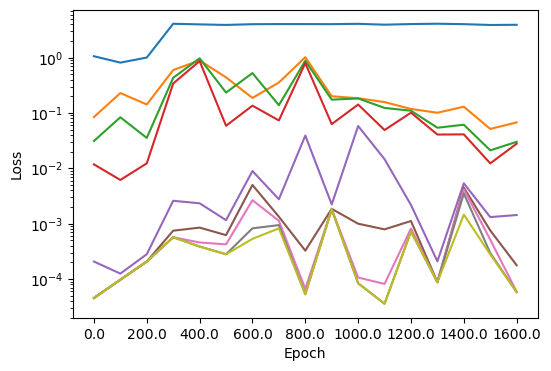

In [8]:
# Vykresleni ztraty
utils.plot_loss_values(loss_values, "Epoch", "Loss")

3000


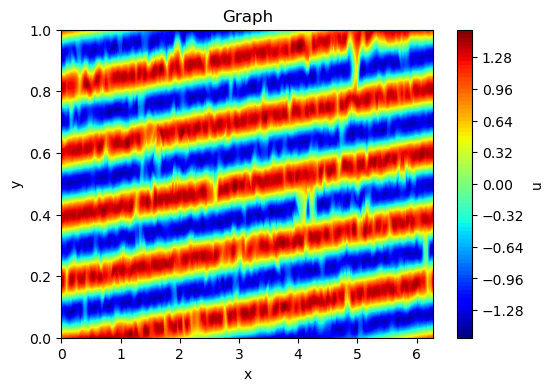

In [9]:
# Vykresleni priblizneho reseni (minus interpolace)
plot_ctx = utils.PlotContext(
    function=model,
    domain=domain,
    patches=[],
    N=3_000
)

utils.plot_function_on_domain(plot_ctx)

3000


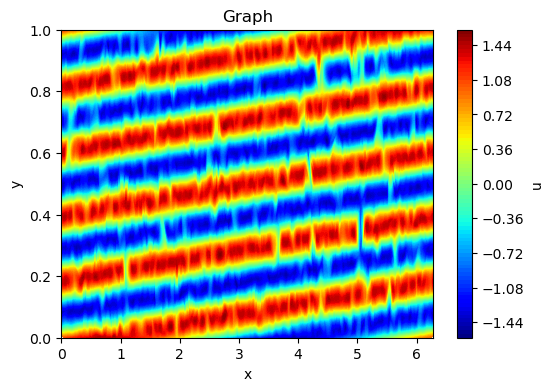

In [10]:
# Vykresleni skutecneho reseni (minus interpolace)
BETA = 30
def solution(x: torch.Tensor) -> torch.Tensor:
    return torch.sin(x[:, 0:1] - BETA * x[:, 1:2]) + torch.cos(x[:, 0:1] - BETA * x[:, 1:2])

plot_ctx.function = solution
plot_ctx.N = 3_000

utils.plot_function_on_domain(plot_ctx)

In [11]:
calc.compute_derivatives_2d(model, domain.interior)

(tensor([[ 1.1619],
         [-0.5272],
         [-1.2001],
         ...,
         [-0.4105],
         [ 1.3618],
         [-1.3106]], device='cuda:0', grad_fn=<SliceBackward0>),
 tensor([[-0.7559],
         [-1.3497],
         [ 0.6955],
         ...,
         [-1.3806],
         [-0.2722],
         [ 0.4638]], device='cuda:0', grad_fn=<SliceBackward0>),
 tensor([[ 22.6805],
         [ 40.4918],
         [-20.8648],
         ...,
         [ 41.4216],
         [  8.1634],
         [-13.9125]], device='cuda:0', grad_fn=<SliceBackward0>))